# Stellar Classification
Data analysis and machine learning with Stellar Classification Dataset - SDSS17, found at https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17/data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

np.random.seed(42)

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17")

In [ ]:
stellar_classification = pd.read_csv("star_classification.csv")
stellar_classification.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Okay, so what we've got above is the first five rows of the stellar classification dataset. It tells us that there's 18 columns in the dataset:


*   Object ID - The value that identifies the object in the image catalogue.
*   Alpha - Right Ascension in degrees
*   Delta - Declination in degrees
*   Light filters - Ultraviolet (u), green (g), red (r), near infrared (i), infrared (z)
*   Run ID - The number used to identify the specific scan
*   Rerun ID - The number used to specify how the image was processed
*   Camera Column - Camera column of the scanline within the run
*   Field ID - Number used to identify each field
*   Spectroscopic Object ID - Unique ID for optical spectroscopic objects. Two different observations with the same spectroscopic object ID will share the same class
*   Class - The class of the object (galaxy, star, quasar)
*   Redshift - The redshift value based on the increase in wavelength
*   Plate - Plate ID for each plate in SDSS17
*   MJD - The modified Julian Date of when the image was taken
*   Fiber ID - The fiber that was pointed at the focal plane in each observation

Only some of these parameters will actually be useful for machine learning, and we must take out the extraneous ones in order to avoid overfitting of the model. Object ID for example won't be useful for this task.

The only columns that we're certain about using are the different light filters. Redshift could be useful (but it could also skew the data towards distance to stars etc), potentially the plate ID, maybe letting it use rerun ID if that affects the predictions given by the AI. And of course, class should be used as the output of the model.




In [ ]:
stellar_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

In [ ]:
stellar_classification.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


In [ ]:
stellar_classification["class"].value_counts()

class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

So pretty much all the stuff above is just taking a deeper look at the dataset. The info tells you that every single value is a number except class, which is an object (but that doesn't really matter because it's the value that's being predicted). Of these numbers, 10 of them are floats (this means they have a decimal point in them) and 7 of these are integers (no decimal point). It's also good because it tells us that there are no values, so every single spot in the dataset has a number.

The describe function shows us some of the overall statistics of the dataset for each column. Note how pretty much every single value has a different "scale" pretty much ie some of them are in millions and some are in tens. This means that we'll have to use some statistical method to normalise them and make them on the same scale.

And all the value counts function does is tell us that nearly 60% of the dataset is galaxies, and around 20% each are stars and quasars. This might be important to take into account because AIs only really like it when everything has around the same number of values for each thing, and it can be very hard to find a performance metric when there isn't an even number of each one.

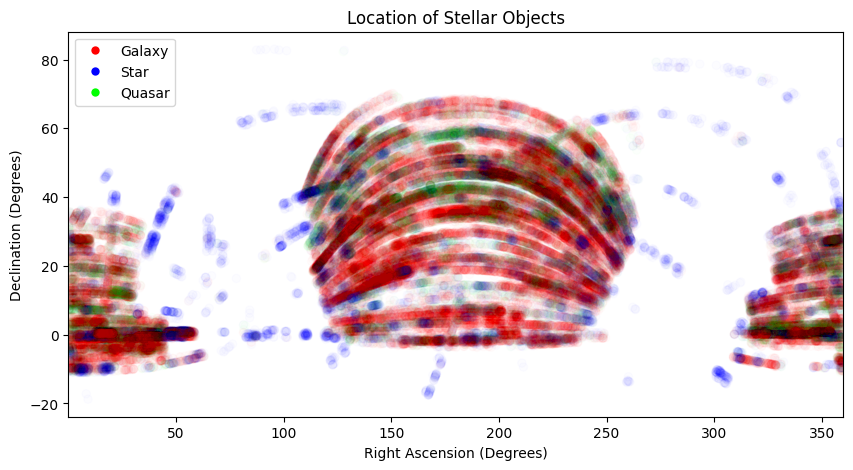

In [ ]:
def getcolour(x):
  if x == "GALAXY":
    return "r"
  elif x == "STAR":
    return "b"
  else:
    return "lime"

colours = stellar_classification["class"].apply(getcolour)
colourlist = [Line2D([0], [0], marker="o", c="none", label="Galaxy", markerfacecolor="r", markeredgecolor="none"),
              Line2D([0], [0], marker="o", c="none", label="Star", markerfacecolor="b", markeredgecolor="none"),
              Line2D([0], [0], marker="o", c="none", label="Quasar", markerfacecolor="lime", markeredgecolor="none")]

plt.rcParams['figure.figsize'] = [10, 5]
plt.scatter(x=stellar_classification["alpha"], y=stellar_classification["delta"], c=colours, alpha=0.01)
plt.xlabel("Right Ascension (Degrees)")
plt.ylabel("Declination (Degrees)")
plt.title("Location of Stellar Objects")
plt.legend(handles=colourlist, loc="upper left")
plt.margins(x=0)
plt.show()

In [ ]:
def galaxy_checker(x):
  if x == "GALAXY":
    return 1
  else:
    return 0

def star_checker(x):
  if x == "STAR":
    return 1
  else:
    return 0

def quasar_checker(x):
  if x == "QSO":
    return 1
  else:
    return 0

stellar_classification_num = stellar_classification.drop(["class", "spec_obj_ID", "plate", "MJD", "fiber_ID",
                                                          "delta", "obj_ID", "run_ID", "alpha", "cam_col", "field_ID",
                                                          "rerun_ID"], axis=1)

stellar_classification_num["GALAXY"] = stellar_classification["class"].apply(galaxy_checker)
stellar_classification_num["STAR"] = stellar_classification["class"].apply(star_checker)
stellar_classification_num["QSO"] = stellar_classification["class"].apply(quasar_checker)

corr_matrix = stellar_classification_num.corr()
print(corr_matrix["QSO"].sort_values(ascending=False), end="\n\n")
print(corr_matrix["GALAXY"].sort_values(ascending=False), end="\n\n")
print(corr_matrix["STAR"].sort_values(ascending=False), end="\n\n")

QSO         1.000000
redshift    0.756649
i           0.370459
r           0.255142
z           0.024361
g           0.006015
u          -0.006590
STAR       -0.253849
GALAXY     -0.585624
Name: QSO, dtype: float64

GALAXY      1.000000
u           0.023129
g           0.014289
z          -0.008382
r          -0.037997
i          -0.160379
redshift   -0.256925
QSO        -0.585624
STAR       -0.635371
Name: GALAXY, dtype: float64

STAR        1.000000
z          -0.013206
u          -0.021321
g          -0.022780
i          -0.161545
r          -0.197722
QSO        -0.253849
redshift   -0.414245
GALAXY     -0.635371
Name: STAR, dtype: float64



The code above displays correlation matrices for

Figuring out what scale to use and applying it:

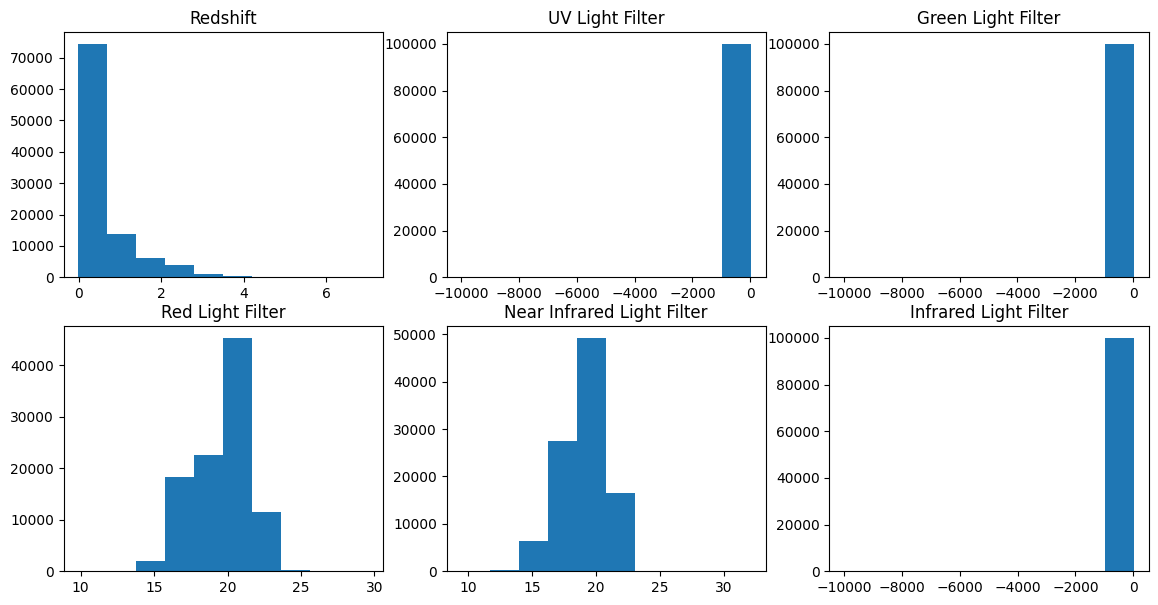

In [ ]:
plt.rcParams['figure.figsize'] = [14, 7]
figure, axis = plt.subplots(nrows=2, ncols=3)

axis[0,0].hist(stellar_classification["redshift"])
axis[0,0].set_title("Redshift")

axis[0,1].hist(stellar_classification["u"])
axis[0,1].set_title("UV Light Filter")

axis[0,2].hist(stellar_classification["g"])
axis[0,2].set_title("Green Light Filter")

axis[1,0].hist(stellar_classification["r"])
axis[1,0].set_title("Red Light Filter")

axis[1,1].hist(stellar_classification["i"])
axis[1,1].set_title("Near Infrared Light Filter")

axis[1,2].hist(stellar_classification["z"])
axis[1,2].set_title("Infrared Light Filter")

plt.show()

From this data, we can see that a few values (red light filter, near infrared light filter) have a normal distribution. This would point to standardisation (the scaling where it follows a normal distribution and forces the standard deviation to equal one). The red light filter looks like it could use either standardisation or normalisation, though a closer look will probably point to normalisation as well.

The interesting filters are the UV filter, green light filter and the infrared light filter. The vast majority of these observations fall into one category, but there must be miniscule amounts of data that fall into the smaller categories. This also points to standardisation because of outliers like this, but this will also need a closer look. One way to do this is by checking the statistics using the describe function.

In [ ]:
print(stellar_classification["redshift"].describe(), "\n\n")
print(stellar_classification["u"].describe(), "\n\n")
print(stellar_classification["g"].describe(), "\n\n")
print(stellar_classification["r"].describe(), "\n\n")
print(stellar_classification["i"].describe(), "\n\n")
print(stellar_classification["z"].describe())

count    100000.000000
mean          0.576661
std           0.730707
min          -0.009971
25%           0.054517
50%           0.424173
75%           0.704154
max           7.011245
Name: redshift, dtype: float64 


count    100000.000000
mean         21.980468
std          31.769291
min       -9999.000000
25%          20.352353
50%          22.179135
75%          23.687440
max          32.781390
Name: u, dtype: float64 


count    100000.000000
mean         20.531387
std          31.750292
min       -9999.000000
25%          18.965230
50%          21.099835
75%          22.123767
max          31.602240
Name: g, dtype: float64 


count    100000.000000
mean         19.645762
std           1.854760
min           9.822070
25%          18.135828
50%          20.125290
75%          21.044785
max          29.571860
Name: r, dtype: float64 


count    100000.000000
mean         19.084854
std           1.757895
min           9.469903
25%          17.732285
50%          19.405145
75%        

Finalising the data before machine learning. The graph and statistical descriptions above show that the best way to put these values on the same scale is with standardisation. For now, the final input columns are going to be redshift and the light filters (will include more if they turn out to be relevant). After this, the data will be ready to be used in machine learning.

In [ ]:
stellar_classification["total"] = stellar_classification["u"] + stellar_classification["g"] + stellar_classification["r"] + stellar_classification["i"] + stellar_classification["z"]

In [ ]:
stellar_classification_final = pd.DataFrame(
    {
        "redshift": stellar_classification["redshift"],
        "u": stellar_classification["u"],
        "g": stellar_classification["g"],
        "r": stellar_classification["r"],
        "i": stellar_classification["i"],
        "z": stellar_classification["z"],
    }
)

stellar_classification_final = StandardScaler().fit_transform(stellar_classification_final)

stellar_classification_final = pd.DataFrame(stellar_classification_final,
                                            columns=["redshift", "u", "g", "r", "i", "z"])

stellar_classification_final["class"] = stellar_classification["class"]
stellar_classification_final.head()

,redshift,u,g,r,i,z,class
0,0.079557,0.059755,0.054926,0.403962,0.046007,0.003937,GALAXY
1,0.277096,0.088045,0.072456,1.584406,1.185097,0.092835,GALAXY
2,0.092423,0.103327,0.067165,0.519745,0.150019,0.008808,GALAXY
3,0.486770,0.004921,0.102210,1.059904,0.807610,0.018321,GALAXY
4,-0.630267,-0.080055,-0.092948,-1.697421,-1.767887,-0.098468,GALAXY


Splitting the data into training and testing data:

In [ ]:
def splitTrainTest(data, testRatio):
  shuffledIndices = np.random.permutation(len(data))
  testSetSize = int(len(data) * testRatio)
  testIndices = shuffledIndices[:testSetSize]
  trainIndices = shuffledIndices[testSetSize:]
  return data.iloc[trainIndices], data.iloc[testIndices]

Train, Test = splitTrainTest(stellar_classification_final, 0.1)

XTrain, yTrain = Train.drop(["class"], axis=1), Train["class"]
XTest, yTest = Test.drop(["class"], axis=1), Test["class"]

# Machine Learning

In [ ]:
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

To start with, we're using an SGD (stochastic gradient descent) classifier. SGD is a crude way of predicting outputs with machine learning, and should not be considered an AI. However, it does classify quickly and effectively, so it's a good way to start.

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(XTrain, yTrain)

SGDClassifier(random_state=42)

In [ ]:
scores = sgd_clf.decision_function([XTrain.iloc[0]])
scores

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[ 1.24035012, -1.37413263, -8.37121964]])

The code above runs the SGD Classifier on a single instance - a galaxy. The output (the array thingy) gives a higher number the more likely the instance belongs to a certain category. The output above tells us that it's most likely a galaxy, a smaller chance of being a star and a very small chance of it being a quasar. That's a pretty good result, but it's just one example.

In [ ]:
yTrainPred = cross_val_predict(sgd_clf, XTrain, yTrain, cv=3)
precisionScore = precision_score(yTrain, yTrainPred, average="macro")
recallScore = recall_score(yTrain, yTrainPred, average="macro")
f1Score = f1_score(yTrain, yTrainPred, average="macro")

print("Precision Score :", precisionScore)
print("Recall Score    :", recallScore)
print("F1 Score        :", f1Score)

Precision Score : 0.9127700427822897
Recall Score    : 0.8771612764542543
F1 Score        : 0.8920493833457117


The code above tells us the precision score, recall score and F1 score of the model, evenly weighted across the classes. Precision score is the percentage of how much of the time the classifier is correct when it says that something belongs to a certain category. What's the percentage chance it's right if it says something is a galaxy?

Recall score is how many cases of a category the classifier detects. This might mean how many galaxies did it say were galaxies vs how many galaxies it said were something else.

F1 score is an overall metric that combines precision score and recall score. The F1 score is around 90%, and while that isn't amazing it's a pretty good start. Now let's look at this accuracy for each category.

In [ ]:
conf_mx = confusion_matrix(yTrain, yTrainPred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
norm_conf_mx


array([[9.51532470e-01, 3.12097271e-02, 1.72578024e-02],
       [9.64624575e-02, 9.03010425e-01, 5.27117254e-04],
       [2.22130513e-01, 9.28553005e-04, 7.76940934e-01]])

[[50946  1671   924]
 [ 1647 15418     9]
 [ 4306    18 15061]]


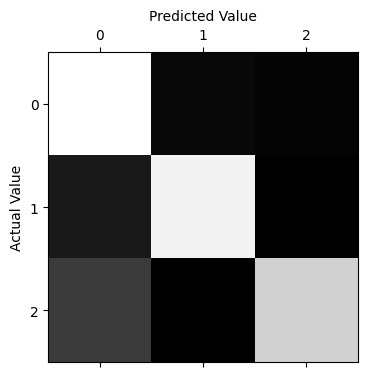

In [ ]:
conf_mx = confusion_matrix(yTrain, yTrainPred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
print(conf_mx)
# np.fill_diagonal(norm_conf_mx, 0)
plt.rcParams['figure.figsize'] = [8, 4]
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Predicted Value", size=10)
plt.ylabel("Actual Value")
plt.show()

The above image is called a confusion matrix. This means that it shows the predicted values vs the actual values in the labels. The top means the predicted values of the data, and the side means the actual values. A whiter square means there is a high number of values in that cell.

Remembering that 0 = Galaxy, 1 = Star and 2 = Quasar, we can read the confusion matrix and see what the model thinks is what. First of all, the model is really good at finding galaxies - if the actual value is a galaxy, it's nearly always predicted as a galaxy. However, the model also predicts that other types of things are galaxies. This could be because there were more galaxies in the dataset, or maybe the other objects really do look like galaxies.

The type of object classified wrong the most is a quasar. These are classified as galaxies a lot. Looking at the numerical version of the confusion matrix above, you can see that nearly a quarter of the time quasars are classified as galaxies. This is much higher than usual considering that the model has 90% accuracy. Note that there were the least number of quasars in the data. This could just be because of there was a way higher amount of galaxies than quasars.

However, we don't think this is the case because there's a similar number of stars and quasars, and stars aren't classified as galaxies anywhere near as much as quasars are. They are only around 10% of the time, which is consistent with the average accuracy for the system.

A possible reason for this could be because of the model itself - Stochastic Gradient Descent models work by drawing a straight line for each parameter and classifies it based on that. It also could be for the kind of classifier. Because machine learning systems can only really classify things into two categories, you need to use several models to sort things into several categories. The SGD classifier above is a one vs all classifier. This means that it sorts each instance into category or not category. One part of the above classifier would separate things into galaxies and not galaxies. The classfier with the highest number is what the instance is classified as.

However, there is another kind of classifier. This is called a one vs one classifier, where a classifier is trained for every single pair of labels. One of these might be galaxy vs stars. Using a one vs one classifier could mean that the algorithm would get better at differentiating between galaxies and other classes.

In [ ]:
ovo_sgd_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_sgd_clf.fit(XTrain, yTrain)

yTrainPred_ovo = cross_val_predict(ovo_sgd_clf, XTrain, yTrain, cv=3)
precisionScore = precision_score(yTrain, yTrainPred_ovo, average="macro")
recallScore = recall_score(yTrain, yTrainPred_ovo, average="macro")
f1Score = f1_score(yTrain, yTrainPred_ovo, average="macro")

print("Precision Score :", precisionScore)
print("Recall Score    :", recallScore)
print("F1 Score        :", f1Score)

Precision Score : 0.9403822713933069
Recall Score    : 0.9451697377850709
F1 Score        : 0.9422782839496828


Almost immediately, we get better results, when all we did was change the types of data that got put into the classifiers. Note that this is also still the same number of classifiers. For OvA, there were three classifiers:


1.   Galaxies vs Not Galaxies
2.   Stars vs Not Stars
3.   Quasars vs Not Quasars

For OvO, there's still three classifiers:


1.   Galaxies vs Stars
2.   Stars vs Quasars
3.   Quasars vs Galaxies

The only thing that has changed is that instead of each attribute being involved in one model, each attribute is involved in two models with increased specifity. Just by changing the data, we've halved the loss of the model, from 10% innacuracy to 5%. This is very good progress.





[[50958  1261  1322]
 [ 1966 15098    10]
 [    7     3 19375]]


Text(0, 0.5, 'Actual Value')

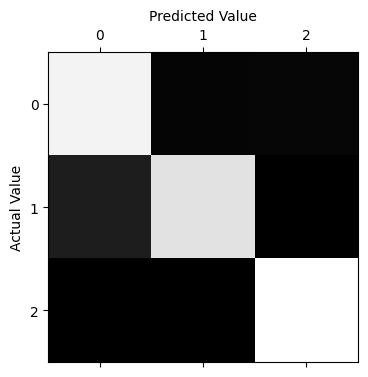

In [ ]:
conf_mx = confusion_matrix(yTrain, yTrainPred_ovo)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
print(conf_mx)

# np.fill_diagonal(norm_conf_mx, 0)
plt.rcParams['figure.figsize'] = [8, 4]
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Predicted Value", size=10)
plt.ylabel("Actual Value")

This is interesting. While this confusion matrix shows the improvement of the one vs one classifier, not everything has improved. Interestingly, slightly more galaxies have been classified as stars when compared to the other confusion matrix. This means that the star vs galaxy classifier was less effective compared to the One vs All classifiers trained on the same data. However there's no clear reason why this might be happening.

Other than that, all the cells have improved, meaning that for SGD, a one vs one classifier is better at classifying this data.

In [ ]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(XTrain, yTrain)
yTrainPred_knn = cross_val_predict(knn_classifier, XTrain, yTrain, cv=3)

tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(XTrain, yTrain)
yTrainPred_tree = cross_val_predict(tree_classifier, XTrain, yTrain, cv=3)

random_forest = RandomForestClassifier()
random_forest.fit(XTrain, yTrain)
yTrainPred_forest = cross_val_predict(random_forest, XTrain, yTrain, cv=3)

In [ ]:
print("F1 Scores")
print("One vs All SGD:         ", f1_score(yTrain, yTrainPred, average="macro")*100)
print("One vs One SGD:         ", f1_score(yTrain, yTrainPred_ovo, average="macro")*100)
print("K Neighbors Classifier: ", f1_score(yTrain, yTrainPred_knn, average="macro")*100)
print("Decision Tree:          ", f1_score(yTrain, yTrainPred_tree, average="macro")*100)
print("Random Forest:          ", f1_score(yTrain, yTrainPred_forest, average="macro")*100)

F1 Scores
One vs All SGD:          89.20493833457117
One vs One SGD:          94.22782839496828
K Neighbors Classifier:  95.97547912371466
Decision Tree:           95.93500090166374
Random Forest:           97.48429070511517


The code above tests out a few different machine learning algorithms and lists their F1 scores. The new algorithms are:


*   **K Nearest Neighbors:** This is a classifier that calculates the probability of an input belonging to a certain class by calculating the input instances closest to it (this one takes the top five) and averaging the results. This is a good algorithm for classification because it's based on instances and in this dataset, two things belonging to the same class are probably fairly close in terms of light emitted and redshift, which are the inputs of the model. However this is probably not the best algorithm because it isn't very versatile and can be hard to improve.
*   **Decision Tree:** Decision trees are a simple but powerful machine learning algorithm that can find subtle differences in the data by splitting it into smaller and smaller homogenous subsections and working up from there. These are generally a reliable machine learning algorithms, however the way a decision tree splits the data really affects the way it works as a classifier
*   **Random Forest:** A random forest classifier is made up of a heap of decision trees that all split the data differently, and then different algorithms are used to optimise this and create a more holistic model with more accurate predictions. They're probably the closest algorithm to AI in here, and are very good at picking up on tiny differences between classes. The downside is that these take up a lot of time to train on and predict from data.

All of these were good classifiers, with the K Neighbors and Decision Tree being at around 96% and the Random Forest at around 97.5% in F1 score. These are both pretty good scores, but the one with the most potential to change parameters is the Random Forest Classifier. This is because it is more complicated, and while complicated does not always mean better in machine learning, the higher scores in more fitted models means that this is a complicated dataset with complicated relationships between the input data and the classes they're part of.



[[52843   610    88]
 [ 1223 15848     3]
 [   15     0 19370]]


Text(0, 0.5, 'Actual Value')

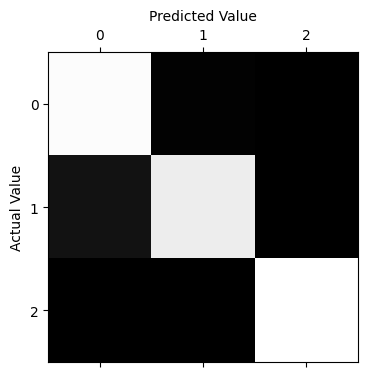

In [ ]:
conf_mx = confusion_matrix(yTrain, yTrainPred_forest)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
print(conf_mx)

# np.fill_diagonal(norm_conf_mx, 0)
plt.rcParams['figure.figsize'] = [8, 4]
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.title("Predicted Value", size=10)
plt.ylabel("Actual Value")

The confusion matrix above is for the random forest classifier and it's super weird. The data for quasars is absolutely fine - they're being classified insanely well, with out of nearly 20,000 instances, they've been classified as galaxies 14 times and as stars 0 times. The predictions for galaxies are also very good with the number of instances classified wrong going from around 2500 to 700 ish. That's also good.

The bright white square is for stars classified as galaxies, and while this is still very high (around 9% of the time, stars are incorrectly classified as galaxies) it's half the size that it was which is still pretty good.

There must be some way to minimise this error. The only remaining big problem is galaxies and stars being classified as eachother

In [ ]:
type(yTrainPred)

numpy.ndarray

# Refining the Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression

In [ ]:
TrainGS = Train.loc[Train["class"] != "QSO"]
TrainGS["class"] = Train["class"] == "GALAXY"
yTrainGS, XTrainGS = TrainGS["class"], TrainGS.drop(["class"], axis=1)

<ipython-input-11-2fa8113a0857>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TrainGS["class"] = Train["class"] == "GALAXY"


In [ ]:
knnGS = KNeighborsClassifier()
knnGS = knnGS.fit(XTrainGS, yTrainGS)
yTrainPred_knnGS = cross_val_predict(knnGS, XTrainGS, yTrainGS, cv=3)

treeGS = DecisionTreeClassifier()
treeGS.fit(XTrainGS, yTrainGS)
yTrainPred_treeGS = cross_val_predict(treeGS, XTrainGS, yTrainGS, cv=3)

svmGS = SVC(kernel='linear',probability=True)
svmGS.fit(XTrainGS, yTrainGS)
yTrainPred_svmGS = cross_val_predict(treeGS, XTrainGS, yTrainGS, cv=3)


print("K Neighbors Classifier:    ", f1_score(yTrainGS, yTrainPred_knnGS, average="macro")*100)
print("Decision Tree Classifier:  ", f1_score(yTrainGS, yTrainPred_treeGS, average="macro")*100)
print("Support Vector Classifier: ", f1_score(yTrainGS, yTrainPred_svmGS, average="macro")*100)

K Neighbors Classifier:     98.26442859539323
Decision Tree Classifier:   99.7049222052708
Support Vector Classifier:  99.72075291064765


[[19288    97]
 [  904 52637]]
[[19304    81]
 [   87 53454]]
[[19311    74]
 [   85 53456]]


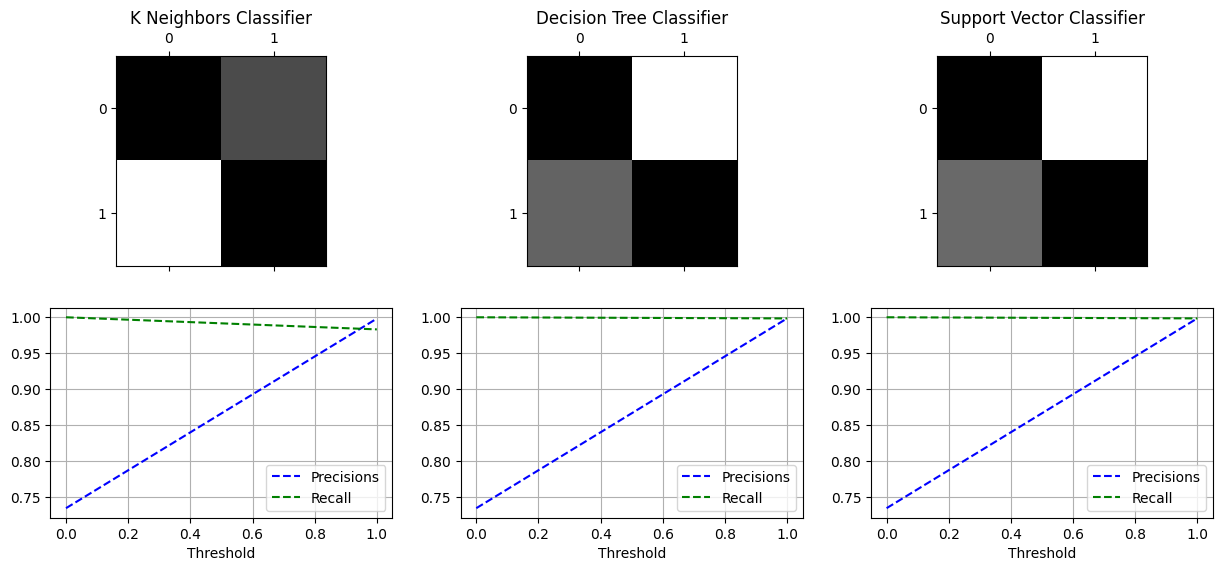

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, obj=plt):
  obj.plot(thresholds, precisions[:-1], "b--", label="Precisions")
  obj.plot(thresholds, recalls[:-1], "g--", label="Recall")
  obj.set_xlabel("Threshold")
  obj.legend(loc="lower right")
  obj.grid()

conf_mx = confusion_matrix(yTrainGS, yTrainPred_knnGS)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
print(conf_mx)

plt.rcParams['figure.figsize'] = [15, 6]
figure, axis = plt.subplots(nrows=2, ncols=3)
axis[0,0].set_title("K Neighbors Classifier")
axis[0,0].matshow(norm_conf_mx, cmap=plt.cm.gray)

precisions, recalls, thresholds = precision_recall_curve(yTrainGS, yTrainPred_knnGS, pos_label=1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, obj=axis[1,0])


tree_conf_mx = confusion_matrix(yTrainGS, yTrainPred_treeGS)
row_sums = tree_conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = tree_conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
print(tree_conf_mx)

axis[0,1].set_title("Decision Tree Classifier")
axis[0,1].matshow(norm_conf_mx, cmap=plt.cm.gray)

precisions, recalls, thresholds = precision_recall_curve(yTrainGS, yTrainPred_treeGS, pos_label=1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, obj=axis[1,1])

svm_conf_mx = confusion_matrix(yTrainGS, yTrainPred_svmGS)
row_sums = svm_conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = svm_conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
print(svm_conf_mx)

axis[0,2].set_title("Support Vector Classifier")
axis[0,2].matshow(norm_conf_mx, cmap=plt.cm.gray)

precisions, recalls, thresholds = precision_recall_curve(yTrainGS, yTrainPred_svmGS, pos_label=1)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, obj=axis[1,2])

plt.show()



What we've decided to do is make a system of machine learning models that work together to classify the data rather than work on "actual AI" (like perceptrons) because the results so far have been surprisingly accurate and using algorithms such as decision trees and knn is a lot more adjustable than trying to work with a AI models.

The code above shows the results of a few different machine learning algorithms on a set of data that is only stars and galaxies.

Because the random forest predicted quasars so well, the final system is going to have quasars classified by the random forest, and then a system called "stacking". In a stacking classifier, the data is run through several different classifiers, and the output from those classifiers is run through another classifier to predict the final output. This stacking classifier will probably be better at telling the difference between stars and galaxies than any singular model is.

In [ ]:
knn_proba = knnGS.predict_proba(XTrainGS)

In [ ]:
models = {"knn": knnGS, "tree": treeGS, "svm": svmGS}
probas = pd.DataFrame()

for n in models:
  model_proba = models[n].predict_proba(XTrainGS)
  probas[n+"galaxy"], probas[n+"qso"] = [a[0] for a in model_proba], [a[1] for a in model_proba]

final_estimator = LogisticRegression()
final_estimator.fit(probas, yTrainGS)
yTrainPred_final = cross_val_predict(final_estimator, probas, yTrainGS, cv=3)
print("Final Estimator: ", f1_score(yTrainGS, yTrainPred_final, average="macro")*100)

Final Estimator:  100.0


# Testing the Stacked Classifier

In [ ]:
predictions = []
models = {"knn": knnGS, "tree": treeGS, "svm": svmGS}
probas = pd.DataFrame()

X = XTest

for n in models:
  model_proba = models[n].predict_proba(X)
  probas[n+"galaxy"], probas[n+"qso"] = [a[0] for a in model_proba], [a[1] for a in model_proba]

for n in range(len(X)):
  if random_forest.predict(X.iloc[[n]]) == "QSO":
    predictions.append("QSO")
  else:
    df_row = probas.iloc[[n]]
    final_pred = final_estimator.predict(df_row)
    predictions.append("GALAXY" if final_pred == True else "STAR")

What this final classifier does is it creates a machine learning pipeline that allows the results to come from multiple classifiers. This first uses a random forest to determine which objects are quasars (because it had very high accuracy, but only for quasars). If the random forest returns that it's a quasar, the model returns that and doesn't do any further calculations. If not, then it runs the data through k neighbours, decision trees, and the support vector classifier. From here it uses logistic regression on the results from these models to finally determine whether the instance is a star or a galaxy.

In [ ]:
from sklearn.metrics import accuracy_score
print("Final Classifier: ", accuracy_score(yTest, predictions)*100)

Final Classifier:  97.72999999999999
